# LASSO回归分析

## $\S1$ Configuration & Data Preparation

In [153]:
# Data Path
Path = "./Raw_Data_4.xlsx"
Dependent_Variable = "USD_index_Close"

In [ ]:
# Data Preparation
## Loading Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline


## Loading Data
Data = pd.read_excel(Path, index_col="日期")

In [155]:
## Data Split & Scale
### Split Features and Label
X = Data.drop(columns=[Dependent_Variable])
y = Data[[Dependent_Variable]]
# X,y = X.values, y.values

In [ ]:
### Split Train, Valid and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Data Scaling
scaler_X, scaler_y = StandardScaler(), StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

## $\S2$ Model Training & Predicting

In [183]:
## Model Training
lasso = sklearn.linear_model.Lasso(alpha=0.05)
lasso.fit(X_train_scaled, y_train_scaled)

,alpha,0.05
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


Text(0.5, 1.0, 'LASSO Regression Prediction')

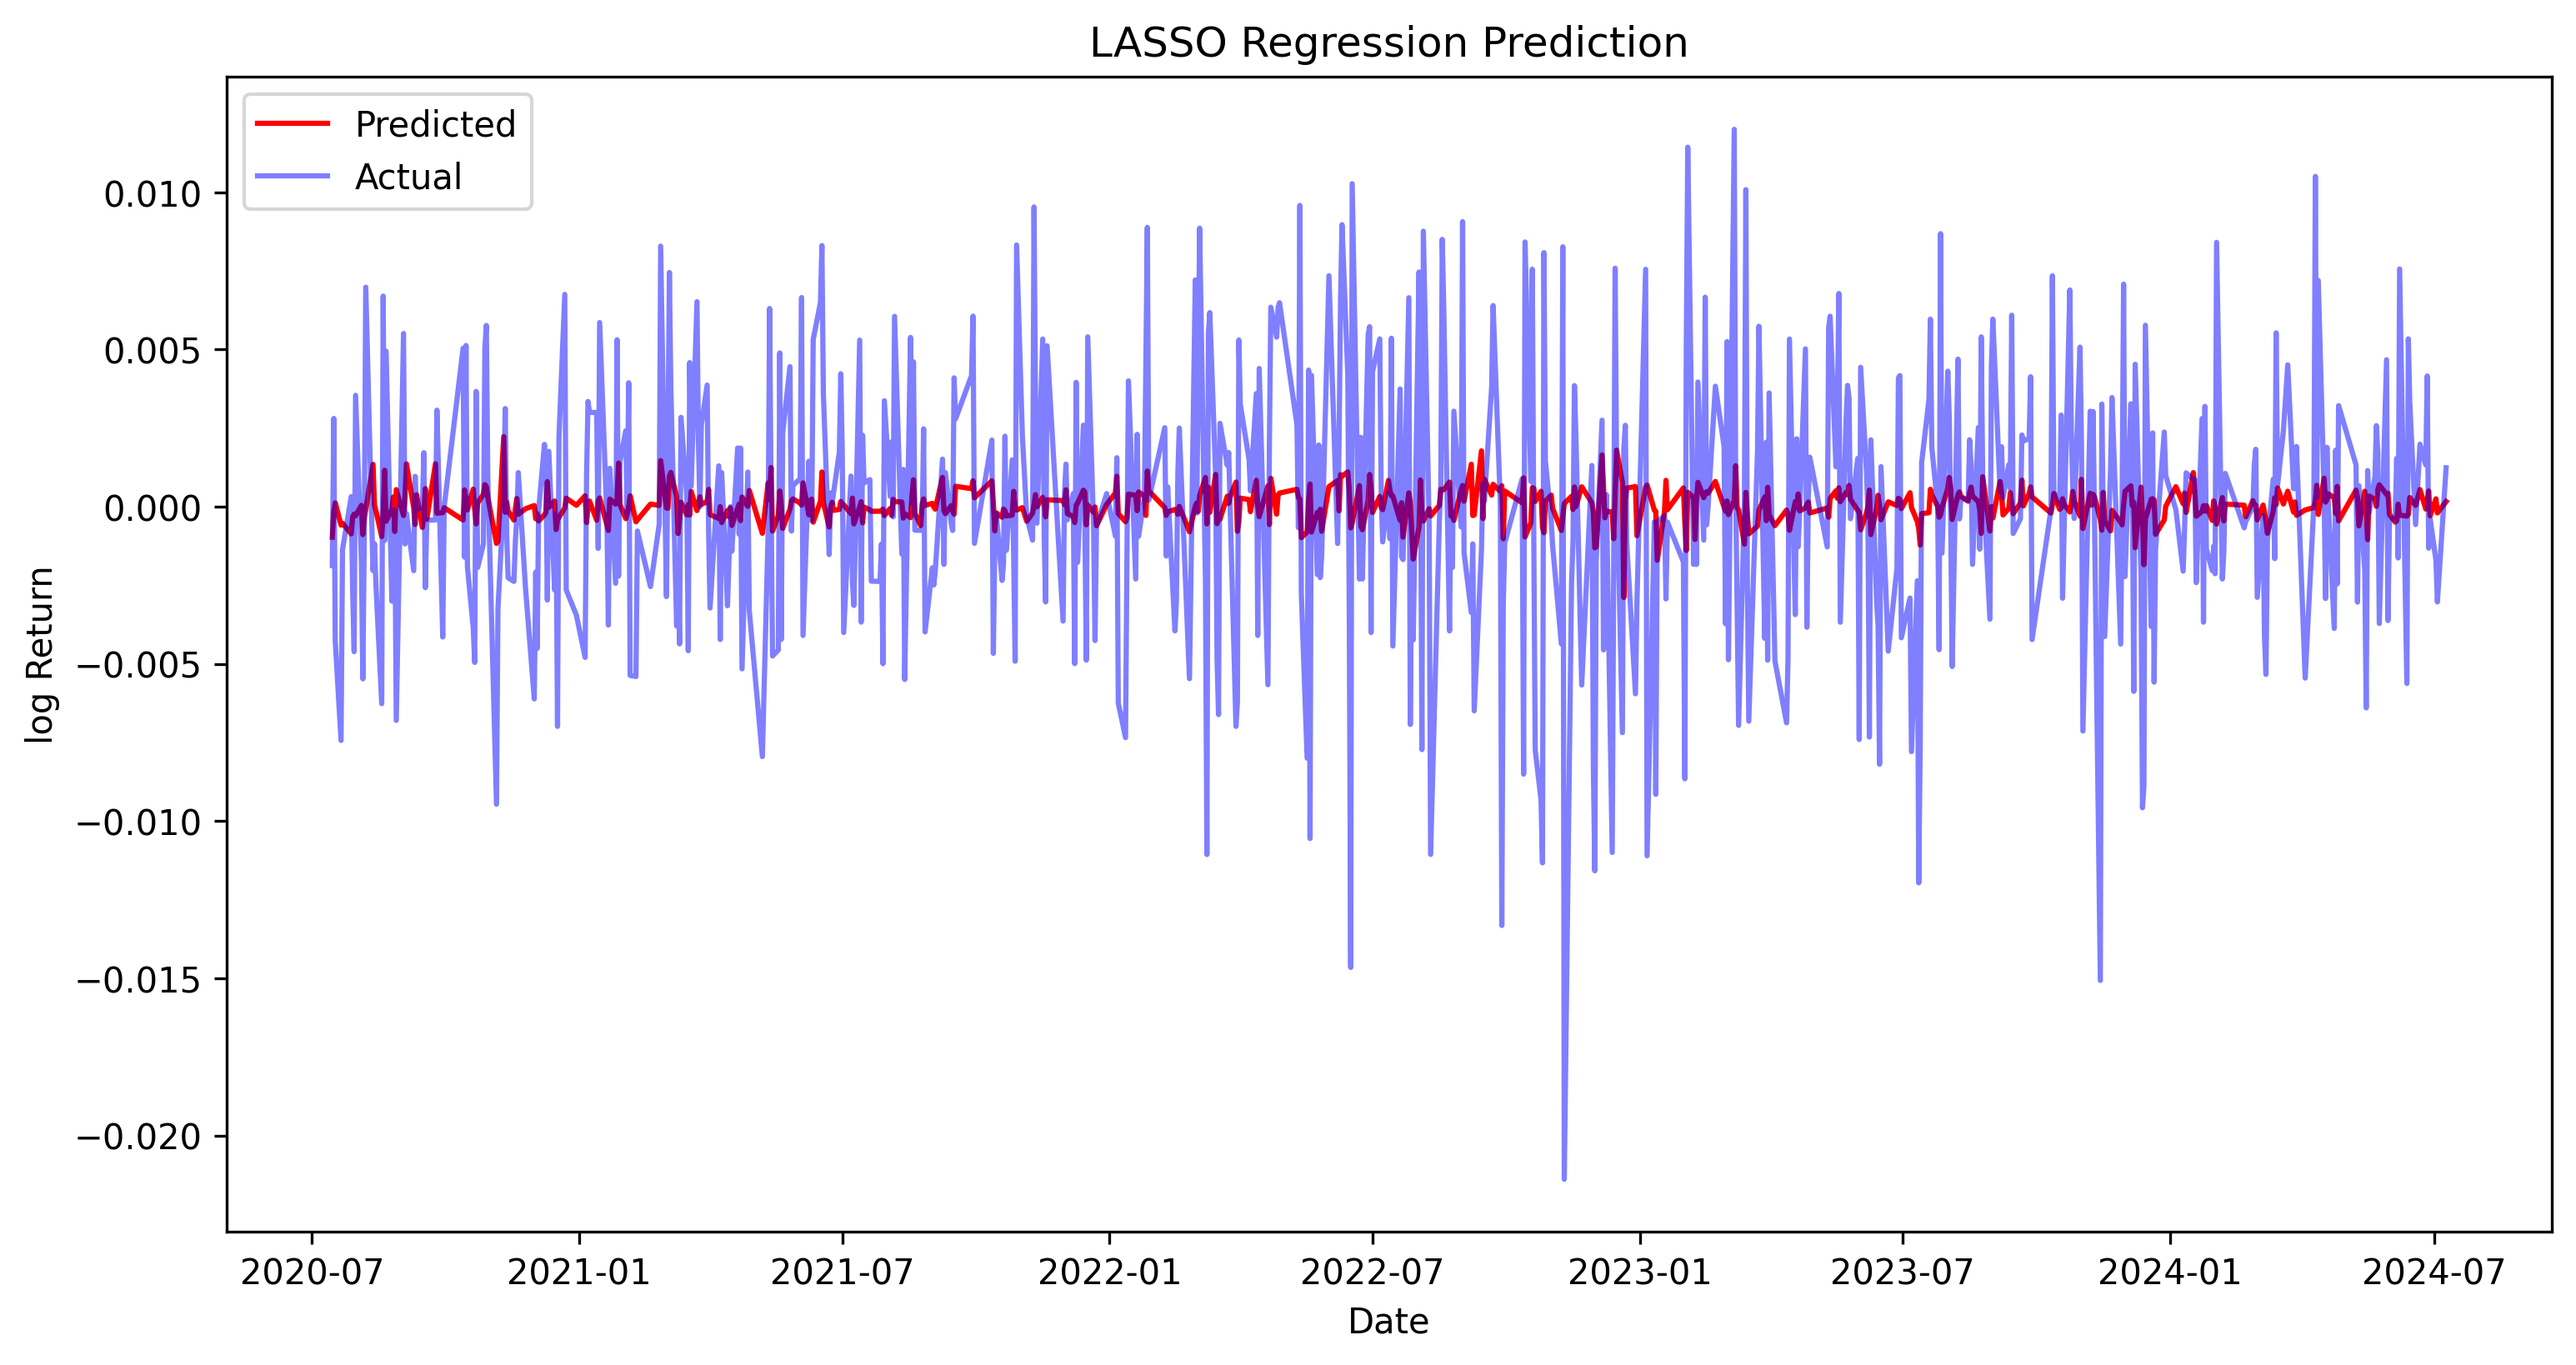

In [184]:
## Model Prediction
y_pred_scaled = lasso.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1))
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=[Dependent_Variable])

### Visualization of Predictions
fig, ax1 = plt.subplots(figsize=(12,6), dpi=300)
ax1.plot(y_pred, label="Predicted", color="red")
ax1.plot(y_test, label="Actual", color="blue", alpha=0.5)

ax1.set_xlabel("Date")
ax1.set_ylabel("log Return")
ax1.legend()
ax1.set_title("LASSO Regression Prediction")

## $\S3$ Model Evaluation & Explanation

In [185]:
## Model Evaluation
from sklearn.metrics import root_mean_squared_error, r2_score
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse,r2

(0.00423934688243148, 0.0249637289411766)

In [ ]:
## Feature Coefficient(Scaled X and y Variables)
feature_coef = dict(zip(X.columns.tolist(), lasso.coef_.tolist()))
### 对一个元组列表进行排序，排序的key是每个回归系数的绝对值，Reversed表示倒序排列
feature_coef = dict(sorted(feature_coef.items(), key=lambda item: abs(item[1]), reverse=True))
feature_coef

dict_items([('USD_EUR_Open', 0.0), ('USD_JPY_Open', 0.065067869851383), ('USD_GBP_Open', 0.0), ('USD_CNY_Open', 0.0), ('GOLD_Open', -0.0460673847879747), ('WTI_Open', -0.0), ('US_10Y_Open', -0.0), ('CN_10Y_Open', -0.0), ('UK_10Y_Open', -0.0), ('JP_10Y_Open', -0.0), ('GER_10Y_Open', -0.0), ('VIX_Open', 0.0), ('US_index_Open', -0.05726624193499278), ('CN_index_Open', -0.0009630264328755011), ('UK_index_Open', -0.0), ('JP_index_Open', -0.0), ('GER_index_Open', -0.0), ('US_10Y-CN_10Y_Open', -0.0), ('US_10Y-GER_10Y_Open', 0.0), ('US_10Y-UK_10Y_Open', 0.0), ('US_10Y-JP_10Y_Open', -0.0), ('CN_10Y-GER_10Y_Open', 0.0), ('CN_10Y-UK_10Y_Open', 0.0), ('CN_10Y-JP_10Y_Open', 0.0), ('GER_10Y-UK_10Y_Open', -0.004333664217219471), ('GER_10Y-JP_10Y_Open', -0.0), ('UK_10Y-JP_10Y_Open', -0.0), ('VIX_Delta', 0.023111657281550544)])